# Intersectional Fairness: End-to-end demonstration

This notebook demonstrates how to use the data utilities provided by the package to prepare a health dataset and perform intersectional fairness analysis functions, including visualisations. 

> **Note:**
> Model training is included in this notebook only to generate predictions (y_pred) for demonstration purposes.
> The data loading, preprocessing, and grouping modules are model-agnostic and can be used with any classifier that produces predictions aligned to the test set.


In [1]:
from fairness.data import load_heart_csv
from fairness.preprocess import add_age_group, map_binary_column, \
                                apply_transforms, preprocess_tabular, \
                                make_train_test_split
from fairness.groups import make_eval_df
from fairness.adapters import unpack_eval_df, make_subject_labels_dict
from fairness.metrics import all_intersect_accs, max_intersect_acc_ratio, \
                             intersect_for, max_intersect_for_ratio, \
                             intersect_fnr, all_intersect_fors, \
                             all_intersect_fnrs, max_intersect_fnr_diff
from fairness import metrics
from fairness import visualisation as vis

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

from pathlib import Path

## Load the dataset

This demo uses the `heart.csv` file. 

Heart failure is a common event caused by cardiovascular diseases, and this dataset contains 11 features that can be used to predict possible heart failure.


In [2]:
ROOT = Path.cwd().parent if Path.cwd().name == "examples" else Path.cwd()
DATA_PATH = ROOT / "data" / "heart.csv"

df_raw = load_heart_csv(DATA_PATH)
df_raw.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


## Fairness-oriented preprocessing

Continuous protected attributes (like age) are binned into a small number of categories
to produce interpretable groups and avoid tiny subgroup sample sizes.

There is an optional mapping for a binary protected attribute (e.g. `Sex` from `"M"/"F"` to `1/0`),
depending on how the dataset encodes it.


In [3]:
# Add a protected attribute for fairness analysis
df_fair = add_age_group(df_raw, age_col="Age", new_col="age_group",
                        bins=(0, 55, 120), labels=("young", "older"))

# map binary/categorical encodings if needed (if dataset has M/F)
if "Sex" in df_fair.columns and df_fair["Sex"].dtype == object:
    df_fair = map_binary_column(df_fair, col="Sex", mapping={"M": 1, "F": 0})

df_fair[["Age", "age_group", "Sex"]].head()

,Age,age_group,Sex
0,40,young,1
1,49,young,0
2,37,young,1
3,48,young,0
4,54,young,1


### Using `apply_transforms`

`apply_transforms` allows multiple `DataFrame -> DataFrame` operations to be chained togther. 


In [4]:
df_fair2 = apply_transforms(
    df_raw,
    transforms=[
        lambda d: add_age_group(d, age_col="Age", new_col="age_group"),
        lambda d: map_binary_column(d, col="Sex", mapping={"M": 1, "F": 0}),
    ],
)

df_fair2[["Age", "age_group", "Sex"]].head()

,Age,age_group,Sex
0,40,young,1
1,49,young,0
2,37,young,1
3,48,young,0
4,54,young,1


## Model-oriented preprocessing

In the raw dataset, variables are represented using a mixture of numeric and categorical encodings, reflecting how the data were originally defined and collected.

Binary clinical indicators such as `FastingBS (0, 1)` are passed through unchanged.

Variables that represent categorical concepts with 2 or ,ore possible values, such as `ChestPainType (TA, ATA, NAP, ASY)` are converted into nuermic features using one-hot encoding. This creates binary indicator columns that take value `True` if the category applies to the individual, else `False`.

This allows interpretation by machine learning models.

Some protected characteristics, such as sex, may be clinically relevant predictors
and are therefore retained in the model inputs. Derived protected attributes used
only for fairness analysis (e.g. `age_group`) are excluded. 

In [5]:
df_model = preprocess_tabular(df_fair, drop_cols=("age_group",))
df_model.head()

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,1,140,289,0,172,0.0,0,True,False,False,True,False,False,False,True
1,49,0,160,180,0,156,1.0,1,False,True,False,True,False,False,True,False
2,37,1,130,283,0,98,0.0,0,True,False,False,False,True,False,False,True
3,48,0,138,214,0,108,1.5,1,False,False,False,True,False,True,True,False
4,54,1,150,195,0,122,0.0,0,False,True,False,True,False,False,False,True


## Train/test split 

`make_train_test_split` returns a `SplitData` container:
- `X_train`, `X_test`
- `y_train`, `y_test`

Derived protected attributes (e.g. `age_group`) are dropped from the model features for training.


In [6]:
split = make_train_test_split(
    df_model,
    target_col="HeartDisease",
    test_size=0.3,
    random_state=42,
    stratify=True,
)

split.X_train.shape, \
    split.X_test.shape, \
    split.y_train.shape, \
    split.y_test.shape

((642, 15), (276, 15), (642,), (276,))

## Train a model to generate `y_pred`

This step is outside of the toolkit's data loading and processing modules.
It is included here to show how `y_pred` can be 
produced for fairness metrics.


In [7]:
model = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000))
])

model.fit(split.X_train, split.y_train)
y_pred = model.predict(split.X_test)

print("\nClassification report:")
print(classification_report(split.y_test, y_pred))


Classification report:
              precision    recall  f1-score   support

           0       0.90      0.84      0.87       123
           1       0.88      0.92      0.90       153

    accuracy                           0.88       276
   macro avg       0.89      0.88      0.88       276
weighted avg       0.88      0.88      0.88       276



The table abvove simmarises the predictive performance of the trained classifier on the test set, using standard classification metrics.

Each row corresponds to one outcome class:
- Class 0: no heart disease
- Class 1: heart disease present


Accuracy is the proportion of all test-set predictions that are correct An accuracy of 0.88 means the model predicts the correct outcome for 88% of patients in the test set. In this example, the classifier achieves good accuracy, providing a suitable baseline for fairness analysis.

## Make an evaulation DataFrame

The `eval_df` DataFrame brings together all information required for fairness analysis in a single, aligned table.

A list of protected attributes is provided to define intersectional groups (for example, sex and age group).

Each row corresponds to one individual in the test set, with the following columns:

- `subject_label`, the individual’s intersectional protected group
- `y_pred`, the model’s prediction
- `y_true`, the true outcome

Because these columns are aligned row-by-row, fairness metrics can safely compare model performance across protected and intersectional groups.

In [8]:
df_test = df_fair.loc[split.X_test.index]

eval_df = make_eval_df(
    df_test=df_test,
    protected=["Sex", "age_group",],
    y_pred=y_pred,
    y_true=split.y_test.to_numpy(),
)

eval_df.head(5)

,subject_label,y_pred,y_true
351,Sex=1|age_group=young,1,1
596,Sex=1|age_group=older,1,1
491,Sex=1|age_group=older,1,1
794,Sex=1|age_group=young,0,0
544,Sex=0|age_group=older,0,0


## Using the evaluation DataFrame with fairness metrics

Different fairness metrics expect their inputs in slightly different formats.

Many fairness metrics operate on lists, for example:

- a list of group labels
- a list of predictions
- a list of true outcomes

These can be extracted from `eval_df` using helper functions in `adapters.py`:

In [9]:
subject_labels, predictions, true_statuses = unpack_eval_df(eval_df)

subject_labels_dict = make_subject_labels_dict(
    df_test, protected_cols=["Sex", "age_group"]
)

## Example 1: Intersectional Accuracy Differences

This example computes the natural log of the maximum accuracy ratio across all intersectional groups defined by the protected attributes sex and age_group.

A value close to 0 indicates that model accuracy is similar across all intersectional groups.

Larger values indicate greater disparity, meaning some groups benefit from much higher accuracy than others.

In a healthcare context, a large maximum intersectional accuracy difference suggests that the model may perform substantially better for certain demographic groups, raising concerns about equity and potential harm.

In [10]:
all_accs = all_intersect_accs(subject_labels_dict,
                              predictions,
                              true_statuses)
print("Model accuracy in different groups:", all_accs)

maxrat = max_intersect_acc_ratio(subject_labels_dict,
                                 predictions,
                                 true_statuses,
                                 natural_log=False)
print("Maximum intersectional accuaracy ratio:", maxrat)

maxrat_log = max_intersect_acc_ratio(subject_labels_dict,
                                     predictions,
                                     true_statuses,
                                     natural_log=True)
print("Natural log of maximum intersectional accuaracy ratio:", maxrat_log)

Model accuracy in different groups: {'0 + older': 0.9375, '0 + young': 0.9, '1 + older': 0.8901098901098901, '1 + young': 0.8682170542635659}
Maximum intersectional accuaracy ratio: 1.0797991071428572
Natural log of maximum intersectional accuaracy ratio: 0.07677501192900646


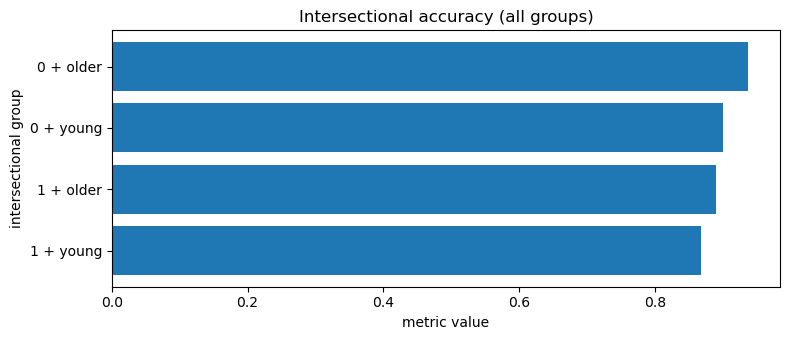

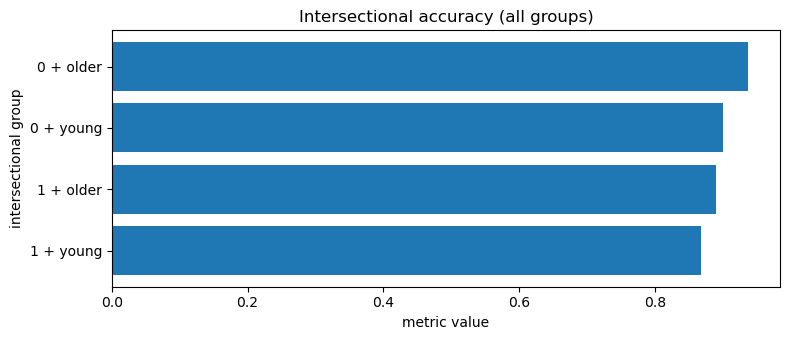

In [11]:
vis.plot_intersectional_metric(
    metrics.all_intersect_accs,
    subject_labels_dict,
    predictions,
    true_statuses,
    title="Intersectional accuracy (all groups)",
)


## Example 2: False Omission Rates

The False Omission Rate (FOR) for a specific intersectional group measures the risk of false reassurance after a negative prediction.

In [12]:
# define the specific intersectional group we want
group_labels_dict = {"Sex": 1, "age_group": "older"}

for_older_male = intersect_for(
    group_labels_dict=group_labels_dict,
    subject_labels_dict=subject_labels_dict,
    predictions=predictions,
    true_statuses=true_statuses,
)

print("False Omission Rate (older males):", for_older_male)

False Omission Rate (older males): 0.3076923076923077


Now let's look at the false omission rates in all groups.

In [13]:


all_fors = all_intersect_fors(subject_labels_dict, predictions, true_statuses)
print("False omission rates in different groups:", all_fors)

False omission rates in different groups: {'0 + older': 0.0, '0 + young': 0.029411764705882353, '1 + older': 0.3076923076923077, '1 + young': 0.11864406779661017}


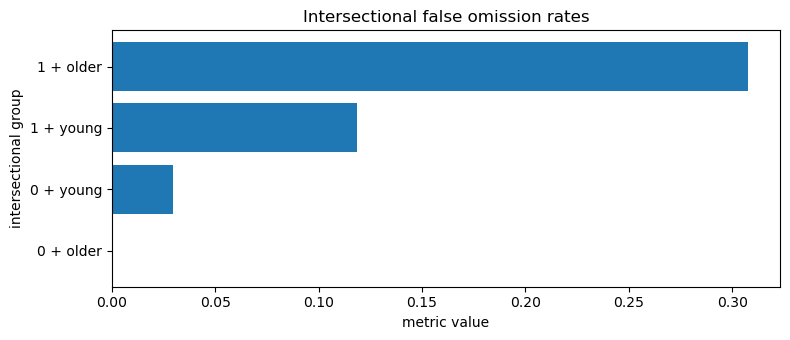

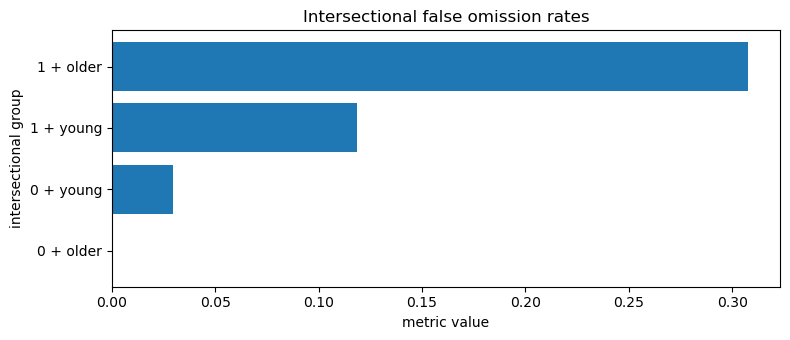

In [14]:
vis.plot_intersectional_metric(
    metrics.all_intersect_fors,
    subject_labels_dict,
    predictions,
    true_statuses,
    title="Intersectional false omission rates",
)


Since one of the false omission rates is zero, the function `max_intersect_acc_ratio` returns a NaN value.

In [15]:
maxrat = max_intersect_for_ratio(subject_labels_dict,
                                 predictions,
                                 true_statuses,
                                 natural_log=False)
print("Maximum intersectional accuaracy ratio:", maxrat)

Maximum intersectional accuaracy ratio: nan


## Example 3: False Negative Rates

The False Negative Rate (FNR) for a specific intersectional group measures the risk of being given a person being assigned a negative prediction given that they do in fact have the disease.

In [16]:
# define the specific intersectional group we want
group_labels_dict = {"Sex": 0, "age_group": "young"}

fnr_young_female = intersect_fnr(
    group_labels_dict=group_labels_dict,
    subject_labels_dict=subject_labels_dict,
    predictions=predictions,
    true_statuses=true_statuses,
)

print("False Omission Rate (young females):", fnr_young_female)

False Omission Rate (young females): 0.25


We can use the functions `all_intersect_fnrs` and `max_intersect_fnr_diff` to find the FNR for each intersectional group and the maximum difference between their rates.

In [17]:
all_fnrs = all_intersect_fnrs(subject_labels_dict,
                              predictions,
                              true_statuses)
print("False negative rates in different groups:", all_fnrs)

maxdiff = max_intersect_fnr_diff(subject_labels_dict,
                                 predictions,
                                 true_statuses)
print("Maximum intersectional FNR difference:", maxdiff)

False negative rates in different groups: {'0 + older': 0.0, '0 + young': 0.25, '1 + older': 0.05263157894736842, '1 + young': 0.1044776119402985}
Maximum intersectional FNR difference: 0.25


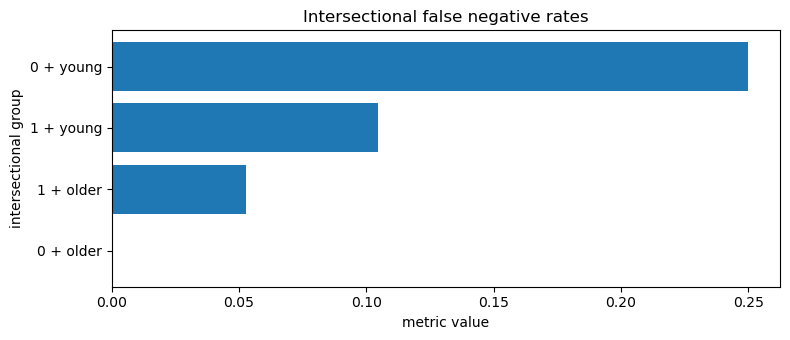

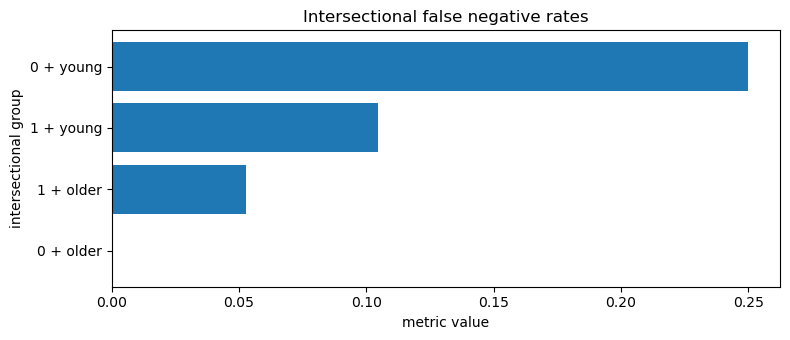

In [18]:
vis.plot_intersectional_metric(
    metrics.all_intersect_fnrs,
    subject_labels_dict,
    predictions,
    true_statuses,
    title="Intersectional false negative rates",
)